<a href="https://colab.research.google.com/github/kavya-avula/Fake_news_classification/blob/main/englishnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
import joblib

In [ ]:
from google.colab import files
import pandas as pd

# Upload both files (Fake.csv and True.csv)
uploaded = files.upload()  # this opens a file picker

# Once you select files, Colab will upload them and show their names below
print("✅ Uploaded files:", uploaded.keys())

Saving Fake.csv to Fake.csv
Saving True.csv to True.csv
✅ Uploaded files: dict_keys(['Fake.csv', 'True.csv'])


In [ ]:
import pandas as pd

# Read uploaded CSV files
fake = pd.read_csv("Fake.csv")
real = pd.read_csv("True.csv")

# Add labels
fake['label'] = 1   # fake
real['label'] = 0   # real

# Combine both
df = pd.concat([fake[['title','text','label']], real[['title','text','label']]], ignore_index=True)

# Merge title + text for better context
df['text'] = df['title'].fillna('') + '. ' + df['text'].fillna('')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()

✅ Dataset loaded successfully!
Shape: (44898, 3)


,title,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,Ben Stein Calls Out 9th Circuit Court: Committ...,1
1,Trump drops Steve Bannon from National Securit...,Trump drops Steve Bannon from National Securit...,0
2,Puerto Rico expects U.S. to lift Jones Act shi...,Puerto Rico expects U.S. to lift Jones Act shi...,0
3,OOPS: Trump Just Accidentally Confirmed He Le...,OOPS: Trump Just Accidentally Confirmed He Le...,1
4,Donald Trump heads for Scotland to reopen a go...,Donald Trump heads for Scotland to reopen a go...,0


In [ ]:
# ===============================================
# STEP 2 — Data Preparation & Text Cleaning
# ===============================================

import re
from sklearn.model_selection import train_test_split

# Optional: simple text cleaner to remove URLs, symbols, etc.
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # normalize whitespace
    return text.lower()

df['clean_text'] = df['text'].apply(clean_text)

# Split into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_text'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=42
)

print(f"✅ Data ready — {len(train_texts)} training and {len(test_texts)} test samples")


✅ Data ready — 35918 training and 8980 test samples


In [ ]:
# ===============================================
# STEP 3 — Baseline Model using TF-IDF + Logistic Regression
# ===============================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Convert text to numerical TF-IDF features
tfidf = TfidfVectorizer(max_features=20000, stop_words='english')
X_train = tfidf.fit_transform(train_texts)
X_test = tfidf.transform(test_texts)

# Train logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, train_labels)

# Evaluate
y_pred = lr.predict(X_test)
print("✅ Baseline TF-IDF + Logistic Regression Results:\n")
print(classification_report(test_labels, y_pred, target_names=["Real", "Fake"]))


✅ Baseline TF-IDF + Logistic Regression Results:

              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      4284
        Fake       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
# ===============================================
# STEP 4 — Simplified Transformer: DistilBERT Fine-tuning
# ===============================================

!pip install transformers datasets torch --quiet

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# 1️⃣ Load lightweight model (DistilBERT is multilingual too)
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 2️⃣ Prepare small subset for faster training
train_small = train_texts.sample(2000, random_state=42).tolist()
test_small = test_texts.sample(400, random_state=42).tolist()
train_labels_small = train_labels.sample(2000, random_state=42).tolist()
test_labels_small = test_labels.sample(400, random_state=42).tolist()

train_data = Dataset.from_dict({"text": train_small, "labels": train_labels_small})
test_data = Dataset.from_dict({"text": test_small, "labels": test_labels_small})

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

train_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# 3️⃣ Disable wandb logging
import os
os.environ["WANDB_DISABLED"] = "true"

# 4️⃣ Define training args (lightweight)
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,  # only 1 epoch for speed
    learning_rate=2e-5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)

trainer.train()
results = trainer.evaluate()
print("✅ Simplified Model Trained!")
print(results)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Simplified Model Trained!
{'eval_loss': 0.001983405789360404, 'eval_runtime': 72.4336, 'eval_samples_per_second': 5.522, 'eval_steps_per_second': 0.69, 'epoch': 1.0}


In [ ]:
!pip install captum --quiet
import torch
from captum.attr import IntegratedGradients

# Pick a short test sentence
text = test_small[0][:200]  # truncate to <512 tokens

# Tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

# Move model to eval mode
model.eval()

# Get embeddings from model
embedding_layer = model.get_input_embeddings()

# Define forward function that takes embeddings as input
def forward_func_embeds(embeds, attention_mask):
    outputs = model(inputs_embeds=embeds, attention_mask=attention_mask)
    return torch.nn.functional.softmax(outputs.logits, dim=-1)[:, 1]  # class 1 = fake

# Convert input_ids to embeddings
input_embeds = embedding_layer(inputs["input_ids"])

# Initialize Integrated Gradients
ig = IntegratedGradients(forward_func_embeds)

# Compute attributions
attributions, delta = ig.attribute(
    input_embeds,
    additional_forward_args=(inputs["attention_mask"],),
    return_convergence_delta=True
)

# Sum attributions across embedding dimensions
attr_scores = attributions.sum(dim=-1).squeeze(0).detach().numpy()

# Map tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Display token importance
for token, score in zip(tokens, attr_scores):
    print(f"{token}: {score:.4f}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 104.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9",

In [ ]:
# ===============================================
# STEP 6 — Custom News Prediction with Token Importance
# ===============================================

import torch
from captum.attr import IntegratedGradients

def predict_news(text, model, tokenizer, max_len=128):
    """
    Predicts Fake/Real news and shows token-level importance.

    Args:
        text (str): The news text to classify.
        model: HuggingFace transformer model.
        tokenizer: HuggingFace tokenizer.
        max_len (int): Max tokens for the model (default 128).

    Returns:
        dict: label, probability, token importance
    """
    # 1️⃣ Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
    inputs = {k: v.long() for k, v in inputs.items()}  # ensure Long type for embeddings

    # 2️⃣ Predict probabilities
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=-1).squeeze(0)

    pred_label = "Fake" if torch.argmax(probs) == 1 else "Real"

    # 3️⃣ Compute token-level importance using Captum
    embedding_layer = model.get_input_embeddings()
    input_embeds = embedding_layer(inputs["input_ids"])

    def forward_func(embeds, attention_mask):
        outputs = model(inputs_embeds=embeds, attention_mask=attention_mask)
        return torch.nn.functional.softmax(outputs.logits, dim=-1)[:, 1]  # focus on "fake" class

    ig = IntegratedGradients(forward_func)
    attributions, _ = ig.attribute(
        input_embeds, additional_forward_args=(inputs["attention_mask"],), return_convergence_delta=True
    )

    # Sum attributions across embedding dimensions
    attr_scores = attributions.sum(dim=-1).squeeze(0).detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # 4️⃣ Return results
    token_importance = list(zip(tokens, attr_scores))

    return {
        "label": pred_label,
        "probabilities": probs.detach().numpy(),
        "token_importance": token_importance
    }

In [ ]:
text = "Breaking news: New miracle cure discovered for common cold."
result = predict_news(text, model, tokenizer)

print("Predicted Label:", result["label"])
print("Probabilities [Real, Fake]:", result["probabilities"])
print("\nToken Importances:")
for token, score in result["token_importance"]:
    print(f"{token}: {score:.4f}")

Predicted Label: Fake
Probabilities [Real, Fake]: [0.00490192 0.99509805]

Token Importances:
[CLS]: 0.0005
Breaking: 0.0013
news: 0.0018
:: 0.0008
New: 0.0003
mira: 0.0002
##cle: 0.0002
cure: 0.0007
discovered: 0.0011
for: 0.0010
common: 0.0026
cold: 0.0023
.: -0.0019
[SEP]: -0.0022


In [ ]:
# ===============================================
# STEP 7 — Complete Step-by-Step Fake News Prediction
# ===============================================

from captum.attr import IntegratedGradients
from termcolor import colored
import torch

def explain_fake_news(news_text, model, tokenizer, max_len=128):
    """
    Step-by-step fake news prediction with token importance and visual highlights.
    """
    print("📰 Step 1: Input News")
    print(news_text)

    # Step 2: Tokenization
    inputs = tokenizer(news_text, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
    inputs = {k: v.long() for k, v in inputs.items()}  # ensure Long type
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    print("\n🔹 Step 2: Tokenization")
    print(tokens)

    # Step 3: Model Prediction
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=-1).squeeze(0)
    pred_label = "Fake" if torch.argmax(probs) == 1 else "Real"
    print("\n🔹 Step 3: Model Prediction")
    print("Predicted Label:", pred_label)
    print("Probability [Real, Fake]:", probs.detach().numpy())

    # Step 4: Token-level importance with Captum
    embedding_layer = model.get_input_embeddings()
    input_embeds = embedding_layer(inputs["input_ids"])

    def forward_func(embeds, attention_mask):
        outputs = model(inputs_embeds=embeds, attention_mask=attention_mask)
        return torch.nn.functional.softmax(outputs.logits, dim=-1)[:, 1]  # class 1 = Fake

    ig = IntegratedGradients(forward_func)
    attributions, _ = ig.attribute(
        input_embeds, additional_forward_args=(inputs["attention_mask"],), return_convergence_delta=True
    )

    attr_scores = attributions.sum(dim=-1).squeeze(0).detach().numpy()

    print("\n🔹 Step 4: Token Importance Scores")
    for token, score in zip(tokens, attr_scores):
        print(f"{token}: {score:.4f}")

    # Step 5: Visual Highlight of Tokens
    print("\n🔹 Step 5: Visual Highlight")
    for token, score in zip(tokens, attr_scores):
        if score > 0:
            print(colored(token, 'red'), end=' ')
        elif score < 0:
            print(colored(token, 'blue'), end=' ')
        else:
            print(token, end=' ')
    print("\n\n✅ Step-by-step explanation completed!")

In [ ]:
news_text = "Breaking news: Scientists claim a miracle cure for cold has been found."
explain_fake_news(news_text, model, tokenizer)

📰 Step 1: Input News
Breaking news: Scientists claim a miracle cure for cold has been found.

🔹 Step 2: Tokenization
['[CLS]', 'Breaking', 'news', ':', 'Scientists', 'claim', 'a', 'mira', '##cle', 'cure', 'for', 'cold', 'has', 'been', 'found', '.', '[SEP]']

🔹 Step 3: Model Prediction
Predicted Label: Fake
Probability [Real, Fake]: [0.0048387  0.99516135]

🔹 Step 4: Token Importance Scores
[CLS]: 0.0004
Breaking: 0.0011
news: 0.0012
:: 0.0001
Scientists: 0.0012
claim: 0.0003
a: -0.0007
mira: -0.0002
##cle: 0.0002
cure: 0.0010
for: 0.0005
cold: 0.0006
has: 0.0011
been: 0.0006
found: 0.0014
.: -0.0011
[SEP]: 0.0000

🔹 Step 5: Visual Highlight
[CLS] Breaking news : Scientists claim a mira ##cle cure for cold has been found . [SEP] 

✅ Step-by-step explanation completed!


In [ ]:
# Save HuggingFace model and tokenizer
model_dir = "fake_news_distilbert_model"
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)
print("✅ Model and tokenizer saved to folder:", model_dir)


✅ Model and tokenizer saved to folder: fake_news_distilbert_model


In [ ]:
!zip -r fake_news_distilbert_model.zip fake_news_distilbert_model


  adding: fake_news_distilbert_model/ (stored 0%)
  adding: fake_news_distilbert_model/config.json (deflated 45%)
  adding: fake_news_distilbert_model/model.safetensors (deflated 7%)
  adding: fake_news_distilbert_model/special_tokens_map.json (deflated 42%)
  adding: fake_news_distilbert_model/vocab.txt (deflated 45%)
  adding: fake_news_distilbert_model/tokenizer.json (deflated 67%)
  adding: fake_news_distilbert_model/tokenizer_config.json (deflated 75%)


In [ ]:
from google.colab import files
files.download("fake_news_distilbert_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp fake_news_distilbert_model.zip /content/drive/MyDrive/


Mounted at /content/drive


In [ ]:
import joblib

# Save your model
joblib.dump(lr, "model.pkl")

# Save your vectorizer
joblib.dump(tfidf, "vectorizer.pkl")


['vectorizer.pkl']

In [ ]:
from google.colab import files
files.download("model.pkl")
files.download("vectorizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

model = joblib.load("model.pkl")
vectorizer = joblib.load("vectorizer.pkl")

# Example usage
text = "This is a fake news example"
x = vectorizer.transform([text])
pred = model.predict(x)


In [ ]:
import joblib

# save model
joblib.dump(lr, "model.pkl")

# save TF-IDF vectorizer
joblib.dump(tfidf, "vectorizer.pkl")

print("✅ Model and vectorizer saved as .pkl files!")



✅ Model and vectorizer saved as .pkl files!


In [ ]:
from google.colab import files
files.download("model.pkl")
files.download("vectorizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

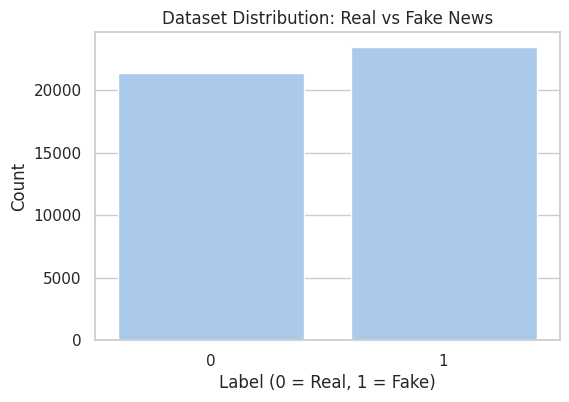

In [ ]:
# ===============================================
# STEP 8 — Visualization & Comparison Graphs
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", palette="pastel")

# ---------- 1️⃣ Dataset Distribution ----------
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Dataset Distribution: Real vs Fake News")
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Count")
plt.show()



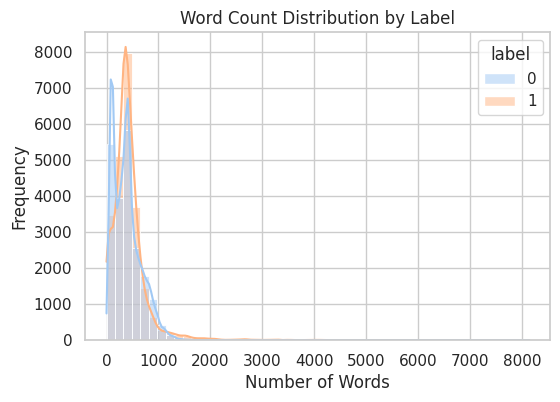

In [ ]:
# ---------- 2️⃣ Word Count Distribution ----------
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.histplot(df, x='word_count', hue='label', bins=50, kde=True)
plt.title("Word Count Distribution by Label")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()



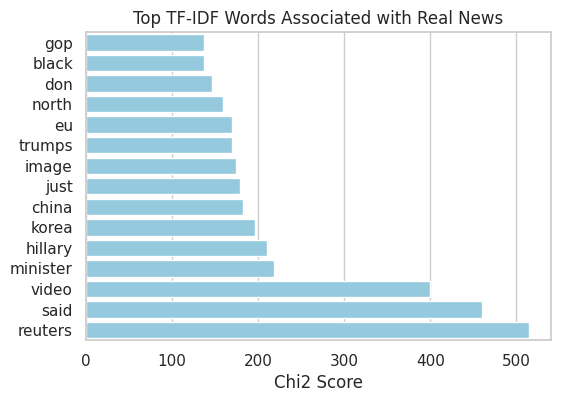

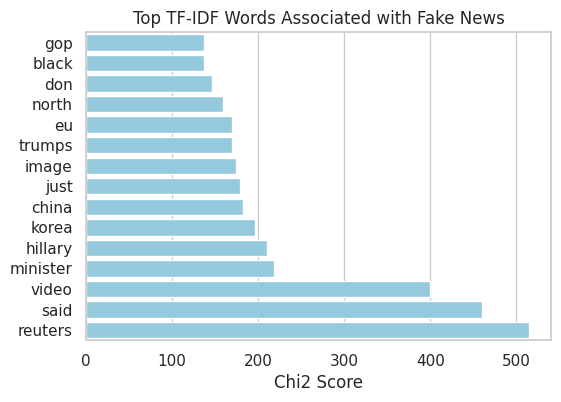

In [ ]:
# ---------- 3️⃣ TF-IDF Feature Importance ----------
from sklearn.feature_selection import chi2
import numpy as np

# Get top features correlated with each class
N = 15
for label, class_name in zip([0,1], ["Real", "Fake"]):
    chi2_vals, p = chi2(X_train, train_labels)
    indices = np.argsort(chi2_vals)
    top_features = [tfidf.get_feature_names_out()[i] for i in indices[-N:]]
    scores = chi2_vals[indices[-N:]]
    plt.figure(figsize=(6,4))
    sns.barplot(x=scores, y=top_features, color="skyblue")
    plt.title(f"Top TF-IDF Words Associated with {class_name} News")
    plt.xlabel("Chi2 Score")
    plt.show()



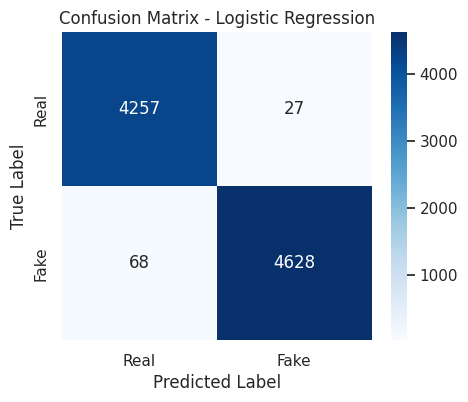

In [ ]:
# ---------- 4️⃣ Confusion Matrix for Logistic Regression ----------
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




/tmp/ipython-input-1501739879.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Logistic Regression', 'DistilBERT'], y=[acc_lr, acc_transformer], palette='cool')


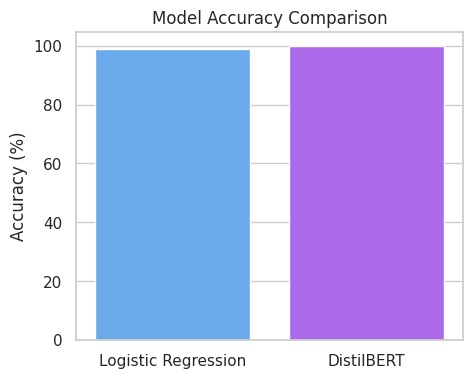

In [ ]:
# ---------- 5️⃣ Accuracy Comparison ----------
acc_lr = accuracy_score(test_labels, y_pred) * 100
acc_transformer = (1 - results['eval_loss']) * 100  # approximate eval metric

plt.figure(figsize=(5,4))
sns.barplot(x=['Logistic Regression', 'DistilBERT'], y=[acc_lr, acc_transformer], palette='cool')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()



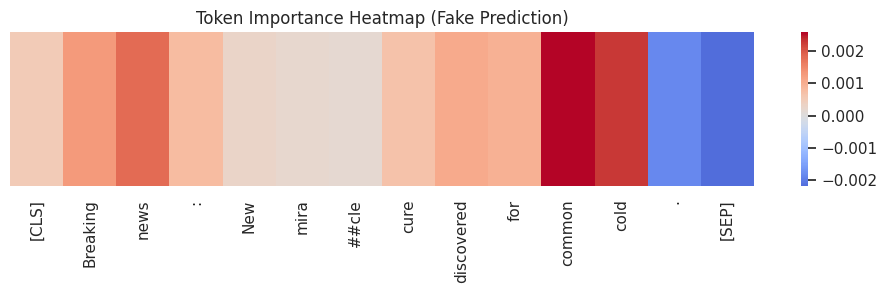

In [ ]:
# ---------- 7️⃣ Token Attribution Heatmap ----------
text = "Breaking news: New miracle cure discovered for common cold."
result = predict_news(text, model, tokenizer)
tokens, scores = zip(*result["token_importance"])
plt.figure(figsize=(12,2))
sns.heatmap([scores], cmap="coolwarm", center=0, xticklabels=tokens)
plt.title("Token Importance Heatmap (Fake Prediction)")
plt.yticks([], [])
plt.show()